In [1]:
import torch

torch.set_default_dtype(torch.float32)
torch.manual_seed(91021)
torch.__version__

'2.2.1+cu121'

# 1. Make classification data

In [2]:
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circles
X, y = make_circles(n_samples, noise=0.03, random_state=91021)

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.2483671  -0.81447779]
 [-0.82877672 -0.18907591]
 [ 0.15490295 -0.77510797]
 [-0.87037195  0.53598668]
 [-0.86404739 -0.00505865]]

First 5 y labels:
[1 1 1 0 1]


In [4]:
import pandas as pd

circles = pd.DataFrame({"X1": X[:, 0], "X2": X[:, 1], "label": y})
circles.head(10)

,X1,X2,label
0,0.248367,-0.814478,1
1,-0.828777,-0.189076,1
2,0.154903,-0.775108,1
3,-0.870372,0.535987,0
4,-0.864047,-0.005059,1
5,0.970214,-0.071646,0
6,0.306635,0.938536,0
7,-0.486692,0.660680,1
8,-0.446776,0.635964,1
9,-0.576145,-0.555555,1


In [5]:
# check different labels count
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

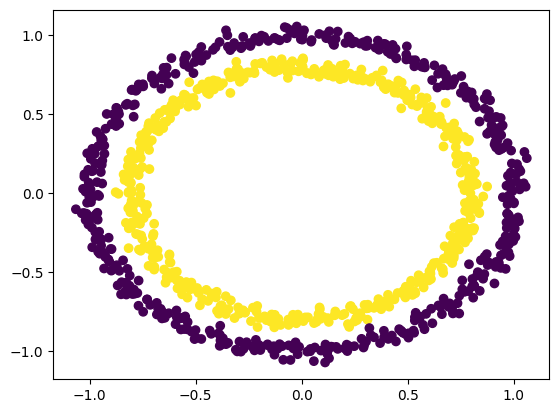

In [6]:
import matplotlib.pyplot as plt

plt.scatter(x=X[:, 0], y=X[:, 1], c=y)

## 1.1 input and output shapes

In [7]:
# check the shapes of inputs and labels
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
# view the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(
    f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}"
)

Values for one sample of X: [ 0.2483671  -0.81447779] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


## 1.2 turn data into tensors and create splits

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.2484, -0.8145],
         [-0.8288, -0.1891],
         [ 0.1549, -0.7751],
         [-0.8704,  0.5360],
         [-0.8640, -0.0051]]),
 tensor([1., 1., 1., 0., 1.]))

In [10]:
# split data into train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=91021
)

# 2. Building the model

In [11]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # takes in 2 features (X) and produces 5 features
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        # takes in 5 features (hidden units) and produces 1 feature (y)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [13]:
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)